# Delta-V

look at: https://pypi.org/project/poliastro/

## Hohmann Transfer

Efficient *in-plane* transfer from one circular orbit to another circular orbit via an eliptical transfer orbit.

<img src="pics/hohmann.png" width="300px">

In [1]:
# reload library
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
np.set_printoptions(precision=1)
np.set_printoptions(suppress=True)
from numpy import pi, sqrt, sin, cos
from matplotlib import pyplot as plt

In [3]:
from doop.smad import dnode, period
from doop.hohmann import hohmann
from doop.constants import Earth, deg2rad, rad2deg
from doop.constants import Moon

In [4]:
ra = Earth.geo # 42164
rb = ra + 300
dv, tof = hohmann(ra, rb) # dvk [m/s], tof [sec]
print(f"> delta-V: {dv*1000:.3f} m/s Time: {tof/60:.1f} min")

> delta-V: 10.880 m/s Time: 721.9 min


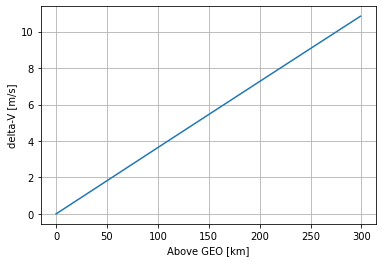

In [5]:
dv = []
for r in range(300):
    dv.append(hohmann(Earth.geo, Earth.geo+r)[0]*1000)
    
plt.plot(dv)
plt.ylabel(f"delta-V [m/s]")
plt.xlabel("Above GEO [km]")
plt.grid(True);

## Maintenance

### East-West

There are 2 stable points that draw objects in orbit to; they are located at longitude 75$^\circ$E and 225$^\circ$E.

$$
\Delta V = 1.715 \sin (2 | l_{desired} - l_{stable}|) [\frac{m/s}{yr}]
$$

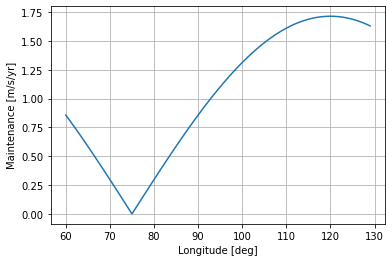

In [6]:
dd = []
ls = 60
le = 130
for l in range(ls,le):
    dv_ew = 1.715*sin(2*abs(l - 75)*deg2rad)
    dd.append(dv_ew)
plt.plot(range(ls, le), dd)
plt.grid(True)
plt.ylabel("Maintenance [m/s/yr]")
plt.xlabel("Longitude [deg]");

### North-South

$$
\Delta V_{moon} = 102.67 \cos (\alpha) \cos(\alpha) \\
\Delta V_{sun} = 40.17 \cos (\gamma) \sin(\gamma)
$$

For an inclination (i) of $0^{\circ}$ (SAMD, 3rd Ed, pg 157): 

- $\Delta V_{moon} = 36.93$ m/s/yr
- $\Delta V_{sun} = 14.45$ m/s/yr 

### Disposal

Assume a super sync of GEO:

In [7]:
# disposal
dv, tof = hohmann(Earth.geo, Earth.geo+300)
print(f"disposal: {ra} -> {ra+300}, dV: {dv*1000:.2f} TOF: {tof/3600:.0f} hrs")

disposal: 42164 -> 42464, dV: 10.88 TOF: 12 hrs


### Mission Life

In [8]:
msn_life = 2
dv_tot = (36.93 + 14.45 + 1.75) * msn_life + 10.88
print(f"Total maintanence dV: {dv_tot:.2f} m/s")

Total maintanence dV: 117.14 m/s


## Drift During Early Ops

The nodal precession ($\Delta N$) or longitudinal precession ($\Delta L$) of an orbit is given by:

$$
P = 2 \pi \sqrt {\frac {a^3} {\mu}} \\
\Delta N = \Delta L = 360^\circ - \frac{360^\circ}{siderialDay} P
$$

where the period (P) is given in seconds while a siderial day is 23 hrs, 56 mins, and 4 sec.

<img src="pics/dn.png" width="500px">

In the ground track above, notice how it doesn't start/end in the same place. Instead it ends *more* West of where it started. 

- Any satellite below GEO (e.g., LEO, MEO), their orbit *appears* to drift across the sky West
- At GEO the orbit is stationary
- Above GEO, they *appear* to drift East

In [9]:
# test
r = Earth.geo + 0
p = period(r)
d = dnode(p)
print(f"R: {r} km dn: {d} deg/day   P: {p/60/60} hrs")

R: 42164 km dn: 0.0017942736157010586 deg/day   P: 23.93432515293841 hrs


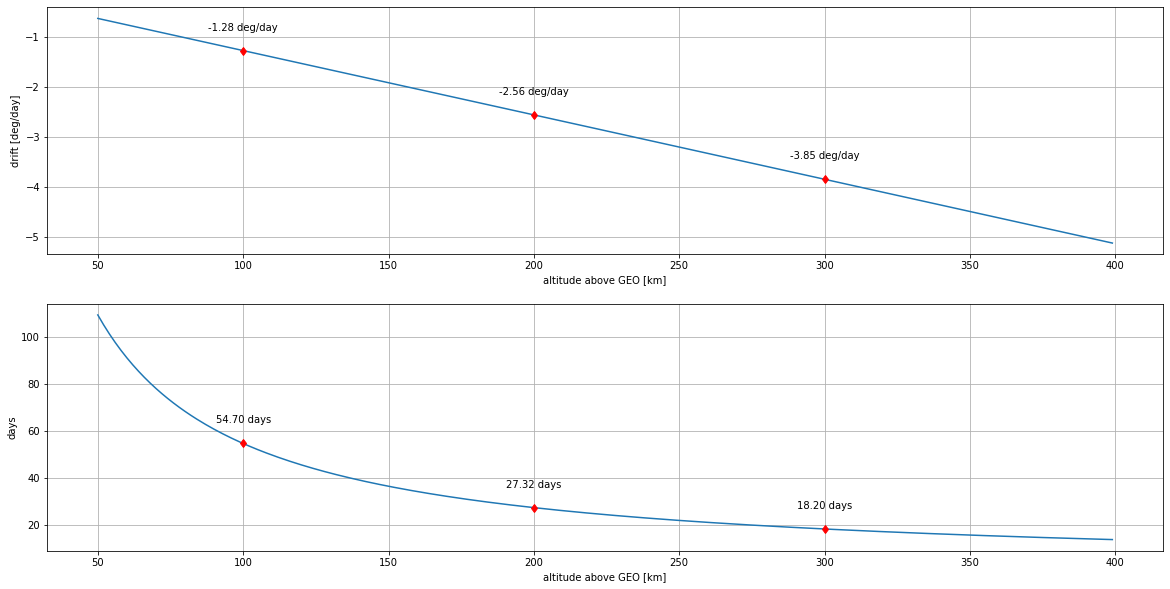

In [10]:
o = []
ddeg = 130-60 # range of longitude ... not sure what this should be
for d in range(50, 400):
    r = Earth.geo + d
    p = period(r)
    deg = dnode(p)
    days = ddeg / abs(deg)
    o.append((r,p,d,deg, days))
    
o = np.array(o)

plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(o[:,2], o[:,3])
plt.grid(True)
plt.xlabel("altitude above GEO [km]")
plt.ylabel("drift [deg/day]");

pts = []
for alt in [100,200,300]:
    pts.append(o[o[:,2] == alt][0])
    
pts = np.array(pts)

plt.plot(pts[:,2], pts[:,3],"rd")

for x,y in zip(pts[:,2], pts[:,3]):
    label = f"{y:.2f} deg/day"
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot(2,1,2)
plt.plot(o[:,2], o[:,4])

plt.plot(pts[:,2], pts[:,4],"rd")

for x,y in zip(pts[:,2], pts[:,4]):
    label = f"{y:.2f} days"
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.grid(True)
plt.xlabel("altitude above GEO [km]")
plt.ylabel("days")
plt.title("");

## Rise and Fall



In [11]:
trade = []
dv_max = list(range(200,350,25))
alts = [100,150,200,250,300]
for dv_msn in dv_max: # m/s
    num = []
    for alt in alts:
        dv1, _ = hohmann(Earth.geo-alt, Earth.geo+alt)
        dv2, _ = hohmann(Earth.geo+alt, Earth.geo-alt)
        # x1000 to get into m/s
        dv = (dv1+dv2)*1000
        
        # integer div causes some msn dv's to collapse onto each other
        # at higher altitudes ... replace with float if you dislike
        num.append(dv_msn // dv)
    trade.append(num)
trade = np.array(trade)

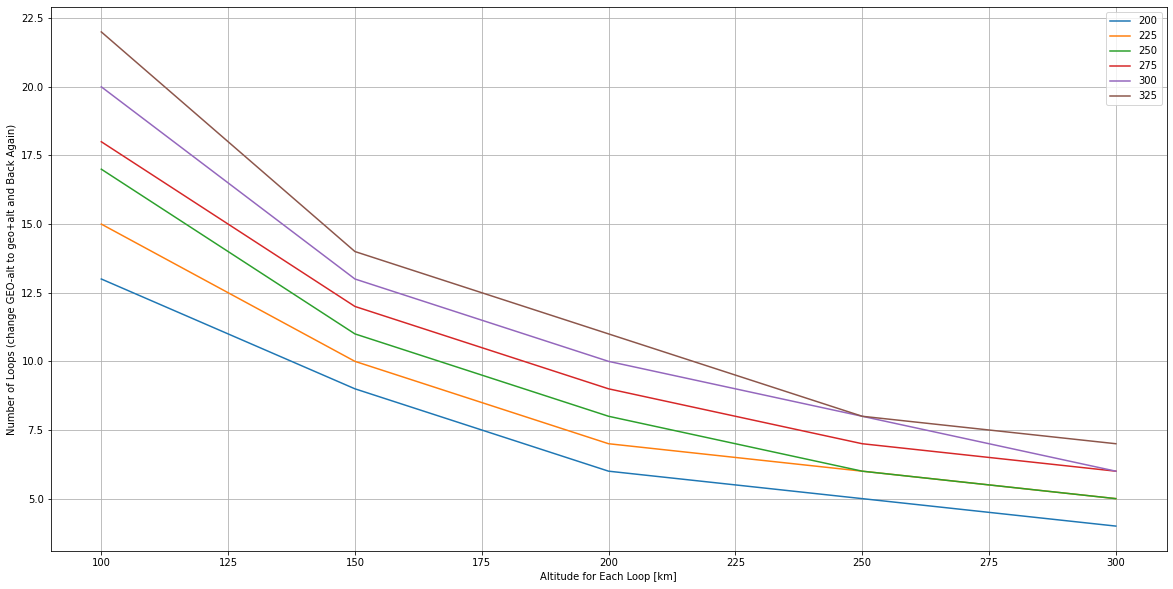

In [12]:
plt.figure(figsize=(20,10))
for i in range(len(dv_max)):
    plt.plot(alts,trade[i,:], label=dv_max[i])
plt.legend()
plt.ylabel("Number of Loops (change GEO-alt to geo+alt and Back Again)")
plt.xlabel("Altitude for Each Loop [km]")
plt.grid(True);

# GEO

We can solve for $a_{GEO}$ by setting the period (P) equal to one siderial day and solving:

$$
a_{GEO} = \sqrt[3]{\mu \left( \frac {P_{siderial}}{2 \pi} \right)^2}
$$

where a siderial day is:

- Earth: 23 hrs, 56 mins, and 4 sec
- Moon: 27 hrs, 43 mins, and 12 sec

In [13]:
geo = np.cbrt(Earth.mu *((23*3600+56*60+4)/(2*np.pi))**2)
print(f"Earth GEO: {geo} km")

Earth GEO: 42164.14010012399 km


In [14]:
# Earth and Sun will end up perturbing this orbit, so it really doesn't exist
# https://astronomy.stackexchange.com/questions/20499/is-it-possible-to-achieve-a-stable-selenostationary-orbit-around-the-moon
lso = np.cbrt(Moon.mu *((27*24*3600 + 7*3600 + 43*60 + 12)/(2*np.pi))**2)
print(f"Moon Lunar stationary oribt (LSO): {lso} km")

Moon Lunar stationary oribt (LSO): 88464.66978099609 km
